#### **Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 17 Nov**

1. Test on all Monday 24 hours data for Connector SB L1

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
#check
print (dataset.iloc[49]['State-EB-L_1'])
print (dataset.iloc[3359]['State-EB-L_1'])

-10.0
7.0


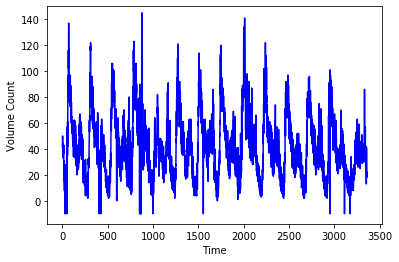

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['Connector-SB-L_1'].values
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
plt.plot(time_num, series, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [5]:
num_days = 11
split_time = num_days*240
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
os.environ['PYTHONHASHSEED']=str(52)
tf.keras.backend.clear_session()
tf.random.set_seed(52)
np.random.seed(52)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 10.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=150, callbacks=[lr_schedule])


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('connector_sb_uni_l1.h5')


In [6]:

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('connector_sb_uni_l1.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 80)          33600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 80)          38720     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                28928     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

[array([[18.304728]], dtype=float32), array([[17.711946]], dtype=float32), array([[17.640984]], dtype=float32), array([[15.879805]], dtype=float32), array([[15.301933]], dtype=float32), array([[14.713572]], dtype=float32), array([[14.3587675]], dtype=float32), array([[14.209982]], dtype=float32), array([[13.792911]], dtype=float32), array([[13.851675]], dtype=float32), array([[14.154652]], dtype=float32), array([[15.2627735]], dtype=float32), array([[13.942232]], dtype=float32), array([[13.2835045]], dtype=float32), array([[12.147161]], dtype=float32), array([[12.483873]], dtype=float32), array([[11.62756]], dtype=float32), array([[12.180159]], dtype=float32), array([[11.884987]], dtype=float32), array([[11.142592]], dtype=float32), array([[10.812424]], dtype=float32), array([[10.39706]], dtype=float32), array([[9.948386]], dtype=float32), array([[9.949173]], dtype=float32), array([[9.862012]], dtype=float32), array([[9.427939]], dtype=float32), array([[9.725975]], dtype=float32), arra

(-15.55, 120)

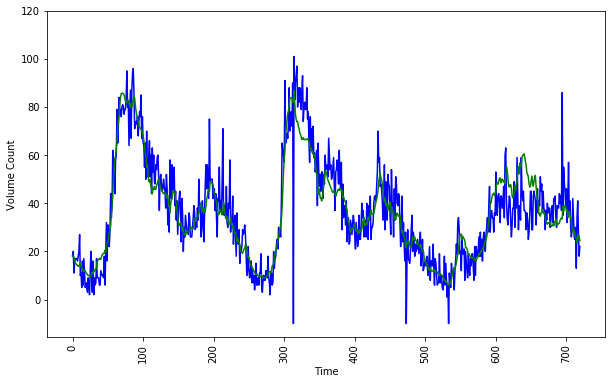

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(new_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
print (forecast)
results = np.array(forecast)[:, 0, 0]
time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, results, color = 'green')
plt.ylim(top=120)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.141033

In [9]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

95.85428

In [10]:
# RMSE 
math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())


9.790519831165918

In [11]:
#Forecast bias
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
print (array_of_errors)
print (forecast_bias)

[-3.04727554e-01  2.28805351e+00 -6.64098358e+00  1.20195389e-01
  1.69806671e+00  2.28642845e+00  2.64123249e+00  1.79001808e+00
  4.20708942e+00  6.14832497e+00  1.28453484e+01 -5.26277351e+00
 -2.94223213e+00 -8.28350449e+00  3.85283947e+00 -6.48387337e+00
  5.37244034e+00 -1.18015862e+00 -6.88498688e+00 -4.14259243e+00
 -5.81242371e+00 -7.39706039e+00 -9.48386192e-01 -2.94917297e+00
 -7.86201191e+00  1.57206059e+00  1.02740250e+01 -1.09126663e+00
 -8.33071423e+00  5.34107304e+00 -1.03702316e+01 -2.57784271e+00
 -6.50159740e+00 -5.68289948e+00  3.80420017e+00 -6.83519459e+00
 -7.23918152e+00 -7.67137146e+00 -1.11200027e+01 -1.08165112e+01
 -4.70464325e+00 -6.87839890e+00 -8.55343628e+00 -8.93076706e+00
 -1.02371731e+01 -1.20898819e+00 -1.44625893e+01  3.22418213e-01
  1.09157410e+01 -7.60620117e+00  7.11688805e+00 -1.31678009e+00
 -5.67795563e+00 -7.40350723e-01  1.32338982e+01 -1.69176102e+00
  1.22710419e+00  1.88417358e+01  3.60567856e+00 -2.26643372e+00
 -1.47434578e+01 -1.78055

In [12]:
# Std. Dev. in Errors
np.std(array_of_errors)

9.785687278737457

In [13]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 7.141033
mean squared error: 95.85428
root mean squared error: 9.790519831165918
forecast_bias: 221.45530605316162
standard dev of errors: 9.785687278737457


## Forecast for Typical Day Slice

In [14]:
typical_actuals = x_valid[:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 6.9519725
mean squared error: 94.12588
root mean squared error: 9.701849173243783
forecast_bias: 654.8950471878052
standard dev of errors: 9.60543491941171


(-15.55, 120)

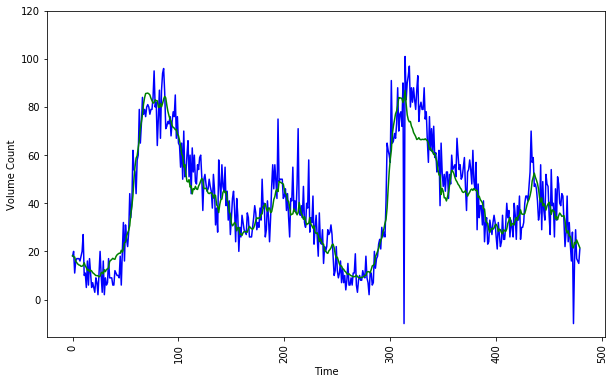

In [15]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecast for Atypical Day Slice

In [16]:
atypical_actuals = x_valid[-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 7.519154
mean squared error: 99.31108
root mean squared error: 9.965494515206819
forecast_bias: -433.43974113464355
standard dev of errors: 9.800482793515291


In [ ]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
forecast = []
results = []

slice_val_time = 480
sliced_val_series = x_valid[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 240
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
#print (sliced_val_series)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual-sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
actuals = sliced_val_actual[-240:]
predictions = sliced_val_series[-240:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals - predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Different Slicing Windows

In [ ]:
forecast = []
results = []
mae_array = []
rmse_array = []
std_array = []

for slice_val_time in range(100, 351, 10):
    #slice_val_time = 480
    sliced_val_series = x_valid[:slice_val_time] 

    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    units_missing = 120
    for t in range(units_missing):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        sliced_val_series = np.append(sliced_val_series, forecast[-1])


    #forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    # print (results)
    #print (sliced_val_series)
    # plt.figure(figsize=(10, 6))
    # plt.xticks(rotation=90)

    sliced_val_actual = x_valid[:slice_val_time+units_missing] 
    sliced_val_times = time_valid[:slice_val_time+units_missing]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    actuals = sliced_val_actual[-units_missing:]
    predictions = sliced_val_series[-units_missing:]

    mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
    print ("mean absolute error: "+ str(mae))
    mae_array.append(mae)
    mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
    print ("root mean squared error: "+ str(rmse))
    rmse_array.append(rmse)
    array_of_errors = (actuals - predictions)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    std_array.append(std_dev_errors)


In [ ]:
print (mae_array)
print (rmse_array)
print (std_array)

## Moving Average Method

In [ ]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [ ]:
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, moving_avg, color = 'green')
plt.ylim(top=150)

# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)
# plot_series(time_valid, moving_avg)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - moving_avg)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
forecast = []
results = []

slice_val_time = 480
sliced_val_series = x_valid[:slice_val_time] 

print (len(sliced_val_series))
# x_val = series[split_time-window_size:]
#sliced_val_series =x_valid

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 240
for t in range(units_missing):
    #forecast.append(series[time:time + window_size].mean())
    #print (t)
    forecast.append(sliced_val_series[t:t + window_size].mean())
    sliced_val_series = np.append(sliced_val_series, forecast[-1])
#     l=len(sliced_val_series)
#     print (l)
#     forecast.append(moving_average_forecast(sliced_val_series, window_size))
#     #print (sliced_val_series[(l-window_size):l])
#     #forecast.append(model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
#     sliced_val_series = np.append(sliced_val_series, forecast[-1])

#print (forecast)
# #forecast = forecast[split_time-window_size:]
# #results = np.array(forecast)[:, 0, 0]
# # print (results)
#print (sliced_val_series)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual - sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Model Performance on 18th March for Simulation Experiment

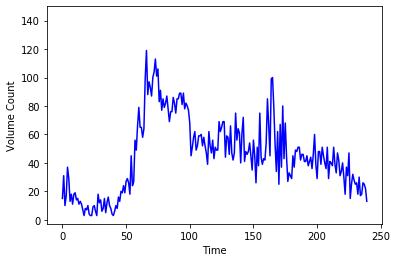

In [7]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]

#extract State-EB-L_1 series for 18th March
series_18march = dataset_original['Connector-SB-L_1'].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(-2.8000000000000007, 150)

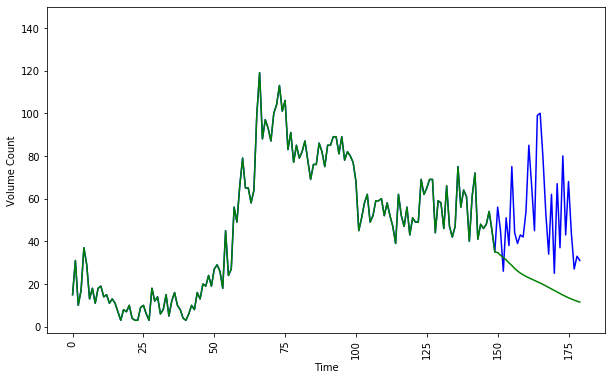

In [8]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+units_missing] 
sliced_val_times = time_18march[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

In [9]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual-sliced_val_series)
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[ 15.  31.  10.  17.  37.  29.  13.  18.  11.  18.  19.  14.  15.  11.
  13.  11.   7.   3.   8.   7.  10.   4.   3.   3.   9.  10.   6.   3.
  18.  12.  14.   6.   8.  15.   5.  12.  16.  10.   8.   4.   3.   6.
  10.   8.  16.  13.  20.  19.  24.  19.  27.  29.  26.  18.  45.  24.
  27.  56.  49.  66.  79.  65.  65.  58.  64.  99. 119.  88.  97.  93.
  87. 100. 104. 113. 101. 106.  83.  91.  77.  85.  79.  82.  87.  78.
  69.  76.  76.  86.  82.  75.  85.  85.  89.  89.  81.  89.  78.  82.
  80.  77.  68.  45.  51.  58.  62.  49.  52.  59.  59.  60.  52.  58.
  52.  47.  39.  62.  52.  47.  56.  43.  51.  49.  49.  69.  62.  65.
  69.  69.  44.  59.  58.  46.  66.  47.  42.  47.  75.  56.  64.  61.
  40.  61.  72.  41.  48.  46.  48.  54.  45.  35.  56.  45.  26.  51.
  38.  75.  44.  39.  43.  42.  54.  85.  66.  45.  99. 100.  79.  53.
  34.  62.  25.  67.  37.  80.  43.  68.  44.  27.  33.  31.]
[ 15.          31.          10.          17.          37.
  29.          13.          

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_connector_sb_l1_univariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_connector_sb_l1_univariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

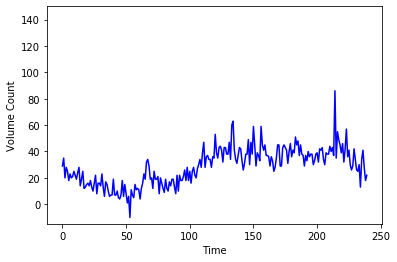

In [10]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 18th March
series_5may = dataset_original['Connector-SB-L_1'].values
time_5may = dataset_original['date_time'].values

time_num_5may = [i for i in range(len(series_5may))]

# Plot the 18th March data
plt.plot(time_num_5may, series_5may, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

[ 29.          35.          20.          28.          25.
  18.          23.          20.          21.          25.
  22.          19.          24.          28.          14.
  19.          25.          12.          13.          15.
  16.          14.          18.          13.          10.
  16.          22.           8.          16.          16.
  14.          23.          13.           6.          17.
  15.          10.           6.           7.           7.
  19.           7.           7.          10.           5.
   4.           7.          18.           6.          15.
   8.           1.           6.         -10.          11.
   7.           5.          15.          11.          12.
  11.           4.          12.          16.          23.
  19.          32.          34.          29.          19.
  20.          12.          25.          19.          19.
  21.           8.          20.          16.          12.
   9.          19.          12.          10.          17.
  14.         

(-14.933883666992188, 150)

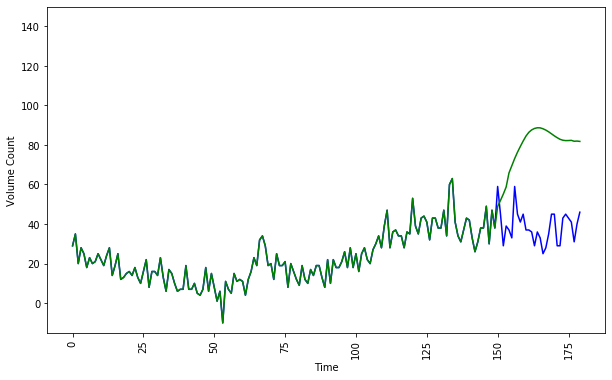

In [11]:
##apply model to the 27th may data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_5may[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
print (sliced_val_series)

sliced_val_actual = series_5may[:slice_val_time+units_missing] 
sliced_val_times = time_5may[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

In [12]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual-sliced_val_series)
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[ 29.  35.  20.  28.  25.  18.  23.  20.  21.  25.  22.  19.  24.  28.
  14.  19.  25.  12.  13.  15.  16.  14.  18.  13.  10.  16.  22.   8.
  16.  16.  14.  23.  13.   6.  17.  15.  10.   6.   7.   7.  19.   7.
   7.  10.   5.   4.   7.  18.   6.  15.   8.   1.   6. -10.  11.   7.
   5.  15.  11.  12.  11.   4.  12.  16.  23.  19.  32.  34.  29.  19.
  20.  12.  25.  19.  19.  21.   8.  20.  16.  12.   9.  19.  12.  10.
  17.  14.  19.  19.  13.   8.  22.  10.  22.  18.  18.  21.  26.  18.
  28.  18.  25.  16.  25.  28.  22.  20.  27.  30.  34.  28.  39.  47.
  28.  36.  37.  34.  34.  28.  36.  35.  53.  39.  35.  43.  44.  41.
  32.  43.  43.  38.  38.  47.  34.  60.  63.  41.  34.  31.  37.  43.
  42.  33.  26.  31.  38.  38.  49.  30.  47.  38.  59.  45.  29.  39.
  37.  33.  59.  45.  41.  45.  37.  37.  36.  29.  36.  33.  25.  28.
  35.  45.  45.  29.  29.  43.  45.  43.  41.  31.  40.  46.]
[ 29.          35.          20.          28.          25.
  18.          23.          

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_connector_sb_l1_univariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_connector_sb_l1_univariate_27may.csv")